# K-Layer Networks on CIFAR-10, AdaGrad, Batch Normalization, Dropout, Data Augmentation, and Hyperparamter Search

## Contents

* [Introduction](#introduction)
* [Imports](#imports)
* [Import Datasets](#import-datasets)
* [Data Pre-Processing](#data-pre-processing)
* [Data Augmentation](#data-augmentation)
* [Model Building](#model-building)
* [Hyperparameter Search](#hyperparameter-search)

## Introduction <a class="anchor" id="introduction"></a>

In this notebook, I built on top of the examples in ```one-layer.ipynb``` and ```two-layer.ipynb```. At the core is the ```Dense``` layer (fully-connected layer) that can have activations such as ```SoftmaxActivation```, and ```ReLUActivation```. The learnable (or trainable) parameters of the ```Dense``` layer can be initialized with the ```XavierInitializer``` and the ```NormalInitializer```, and can be regularized with the ```L2Regularizer```. Further to the \texttt{Dense} layer, batch normalization and dropout were implemented in the ```BatchNormalization``` and the ```Dropout``` layers. Dropout and batch normalization are used to avoid overfitting. A ```Model``` comprises any number of layers, and its loss function is the ```CategoricalCrossEntropyLoss```. The trainable parameters are optimized with the mini-batch gradient descent algorithm with adaptive learning rate via the ```AdaGradOptimizer``` and the learning rate schedule of the optimizer is set to be [```LRCyclingSchedule```](https://arxiv.org/abs/1506.01186). The ```Model``` is first compiled with the loss function, some metrics such as the ```AccuracyMetrics```, and the optimizer, and then it is fit to the data with the ```Model.fit``` method.

In this notebook, it is demonstrated that the library can be used to build a ```Model``` with k-layers. In this notebook, to make it feasible, I implemented an up to five-layer neural network for multi-class classification such that all of the ```Dense``` layers' trainable parameters are initialized with the ```XavierInitializer``` (or the ```NormalInitializer``` when specified) and regularized with the ```L2Regularizer```. The variants of the aforementioned networks also contain a ```BatchNormalization``` and a ```Dropout``` layer after each hidden layer. Note that there is no batch normalization or dropout after the last layer which outputs the scores, or predictions of the network. In the up to five-layer network, there are [50, 30, 20, 10] nodes in the hidden layers. The hidden ```Dense``` layers have ```ReLUActivation``` activations, and the last ```Dense``` layer (classifier) has ```SoftmaxActivation``` activation. The ```Model``` is then compiled with the ```CategoricalCrossEntropyLoss``` loss function, the ```AccuracyMetrics``` performance metric, and the ```SGDOptimizer``` optimizer that uses the ```LRCyclingSchedule``` learning rate schedule.

Data augmentation is used with the aid of the [imgaug](https://github.com/aleju/imgaug) library to further avoid overfitting, on top of dropout and batch normalization. Hyperparamter search is carried out to find the best combination of the newtwork depth (number of layers) and the L2 regularization rate. As in ```two-layer.ipynb```, the [hyperopt](#https://github.com/hyperopt/hyperopt), a Bayesian, distributed hyperparameter optimization library is used. 

## Imports <a class="anchor" id="imports"></a>

Import the library parts and the required packages.

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from sklearn.model_selection import train_test_split
import pickle
from copy import deepcopy
from math import sqrt, ceil
import datetime
import time
import sys
from itertools import product
import pandas as pd
import json
from hyperopt import hp, fmin, tpe, space_eval, STATUS_OK, Trials
import imgaug as ia
import imgaug.augmenters as iaa

from data_utils import load_cfar10_batch, load_label_names
from losses import CategoricalCrossEntropyLoss, LossSmootherConstant
from activations import LinearActivation, ReLUActivation, SoftmaxActivation
from initializers import NormalInitializer, XavierInitializer
from layers import Dense, BatchNormalization, Dropout
from regularizers import L2Regularizer
from models import Model
from metrics import AccuracyMetrics
from optimizers import AdaGradOptimizer
from opt_utils import GradClipperByNothing
from lr_schedules import LRConstantSchedule, LRExponentialDecaySchedule, LRCyclingSchedule
from viz_utils import plot_losses, plot_costs, plot_accuracies, plot_lrs

## Importing Dataset and Data Pre-Processing <a class="anchor" id="importing-dataset-and-data-pre-processing"></a>

In this notebook, the training-validation set is all of ```data_batch_1```, ```data_batch_2```, ```data_batch_3```, ```data_batch_4```, and ```data_batch_5```, that is then randomly split into the  training and the validation sets. Stratified split is used for splitting the train-val set into training and validation sets, that is, the class balance in the two sets are preserved. The test set is ```test_batch```. 

Pre-process datasets by standardization of features (subtract mean of each feature and divide by its standard deviation). Use the training mean and standard deviation on the validation and the test datasets! After this, the mean of each feature in the subsets should be around 0 and the standard deviation should be around 1.

For a finer breakdown of these steps, see ```one-layer.ipynb```.

In [2]:
# Load data
# train and val set are batch 1, 2, 3, 4, and 5, test set is test
path = os.path.join("data", "data_batch_1")
x_train_img_1, y_train_1 = load_cfar10_batch(path)
img_shape = x_train_img_1.shape[1:]

path = os.path.join("data", "data_batch_2")
x_train_img_2, y_train_2 = load_cfar10_batch(path)

path = os.path.join("data", "data_batch_3")
x_train_img_3, y_train_3 = load_cfar10_batch(path)

path = os.path.join("data", "data_batch_4")
x_train_img_4, y_train_4 = load_cfar10_batch(path)

path = os.path.join("data", "data_batch_5")
x_train_img_5, y_train_5 = load_cfar10_batch(path)

x_train_val_img = np.vstack([x_train_img_1, x_train_img_2, x_train_img_3, x_train_img_4, x_train_img_5])
y_train_val = np.hstack([y_train_1, y_train_2, y_train_3, y_train_4, y_train_5])

x_train_img, x_val_img, y_train, y_val = train_test_split(x_train_val_img, y_train_val,
                                                          test_size=0.1, random_state=42,
                                                          stratify=y_train_val)

path = os.path.join("data", "test_batch")
x_test_img, y_test = load_cfar10_batch(path)

# check counts in datasets
print(f"train set shape: {x_train_img.shape}, "
      f"val set shape: {x_val_img.shape}, test set shape: {x_test_img.shape}")
print(f"train labels shape: {y_train.shape},"
      f" val labels shape: {y_val.shape}, test labels shape: {y_test.shape}")

# assert balanced dataset
train_counts = np.unique(y_train, return_counts=True)[1]
train_ratios = train_counts / train_counts.sum()

val_counts = np.unique(y_val, return_counts=True)[1]
val_ratios = val_counts / val_counts.sum()

test_counts = np.unique(y_test, return_counts=True)[1]
test_ratios = test_counts / test_counts.sum()

np.testing.assert_array_equal(train_ratios, val_ratios)
np.testing.assert_array_equal(val_ratios, test_ratios)

np.testing.assert_allclose(train_ratios, val_ratios, rtol=1e-1, atol=0)
np.testing.assert_allclose(val_ratios, test_ratios, rtol=1e-1, atol=0)

print(f"The class ratios in the training set are: {train_ratios}")
print(f"The class ratios in the validation set are: {val_ratios}")
print(f"The class ratios in the test set are: {test_ratios}")

# Pre-process data
x_train_un = x_train_img.reshape(x_train_img.shape[0], -1)
x_val_un = x_val_img.reshape(x_val_img.shape[0], -1)
x_test_un = x_test_img.reshape(x_test_img.shape[0], -1)

x_train = x_train_un / 255.
x_val = x_val_un / 255.
x_test = x_test_un / 255.

mean = np.mean(x_train, axis=0).reshape(1, x_train.shape[1])
std = np.std(x_train, axis=0).reshape(1, x_train.shape[1])

x_train = (x_train - mean) / std
x_val = (x_val - mean) / std
x_test = (x_test - mean) / std

print(y_train)

train set shape: (45000, 32, 32, 3), val set shape: (5000, 32, 32, 3), test set shape: (10000, 32, 32, 3)
train labels shape: (45000,), val labels shape: (5000,), test labels shape: (10000,)
The class ratios in the training set are: [0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]
The class ratios in the validation set are: [0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]
The class ratios in the test set are: [0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]
[1 1 6 ... 8 3 8]


## Data Augmentation <a class="anchor" id="data-augmentation"></a>

Data augmentation is used to further decrease the likelihood of overfitting, that is, it is used a means of regularization. For data augmentation, the [imgaug](https://github.com/aleju/imgaug) library is used.

In [3]:
seq = iaa.Sequential([
        iaa.Fliplr(0.5),  # horizontally flip 50% of the images
        # Small gaussian blur with random sigma between 0 and 0.5.
        # But we only blur about 50% of all images.
        iaa.Sometimes(
            0.5,
            iaa.GaussianBlur(sigma=(0, 0.5))
        ),
    ])

def aug_f(x, seq, img_shape):
    x_img = x.reshape(x.shape[0], *img_shape)
    x_img_aug = seq(images=x_img)
    x = x_img.reshape(x_img_aug.shape[0], -1)

    return x

aug_func = lambda x: aug_f(x, seq, img_shape)

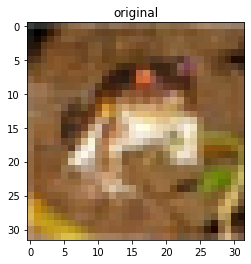

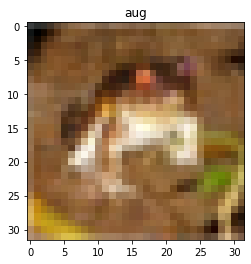

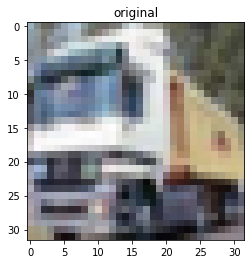

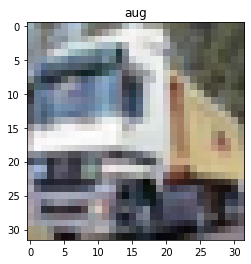

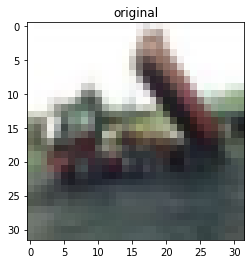

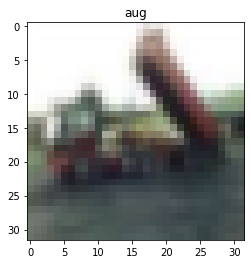

In [4]:
example_imgs = x_train_val_img[:3]
example_imgs_aug = seq(images=example_imgs)

for example_img, example_img_aug in zip(example_imgs, example_imgs_aug):
    plt.imshow(example_img)
    plt.title("original")
    plt.show()
    
    plt.imshow(example_img_aug)
    plt.title("aug")
    plt.show()

## Model Building <a class="anchor" id="model-building"></a>

Define the model building functions and run an example model.

In [5]:
def build_model(dims, reg_rate, in_dim, out_dim, seed):
    params = {"coeff": 1.0, "mean": 0.0, "std": None}

    dims = list(reversed(list(reversed(dims)) + [in_dim])) + [out_dim]

    layers = []

    for n_layer in range(1, len(dims)):
        if n_layer == len(dims) - 1:
            dense = \
                Dense(in_dim=dims[n_layer - 1], out_dim=dims[n_layer],
                      kernel_initializer=XavierInitializer(seed=seed + n_layer, **params),
                      bias_initializer=XavierInitializer(seed=seed + n_layer, **params),
                      kernel_regularizer=L2Regularizer(reg_rate),
                      activation=SoftmaxActivation()
                      )
        else:
            dense = \
                Dense(in_dim=dims[n_layer - 1], out_dim=dims[n_layer],
                      kernel_initializer=XavierInitializer(seed=seed + n_layer, **params),
                      bias_initializer=XavierInitializer(seed=seed + n_layer, **params),
                      kernel_regularizer=L2Regularizer(reg_rate),
                      activation=ReLUActivation()
                      )
            bn = BatchNormalization(momentum=0.9, epsilon=1e-5)
            dropout = Dropout(p=0.9)

        layers.append(dense)

        if n_layer == len(dims) - 1:
            pass
        else:
            layers.append(bn)
            layers.append(dropout)

    model = Model(layers)
    loss = CategoricalCrossEntropyLoss(loss_smoother=LossSmootherConstant())
    
    return model, loss, dims


def compile_model(model, loss, step_size):
    lr_initial = 1e-5
    lr_max = 1e-1
    lr_schedule = LRCyclingSchedule(lr_initial, lr_max, step_size)

    optimizer = AdaGradOptimizer(lr_schedule=lr_schedule, grad_clipper=GradClipperByNothing())

    metrics = [AccuracyMetrics()]

    model.compile_model(optimizer, loss, metrics)
    print(f"len(dims)-1 = {len(dims) - 1}")
    print(model)
    
    return model

Derive the number of epochs needed that is equivalent of the desired number of cylical learning rate schedule cylces. Here 20 epochs.

In [6]:
batch_size = 100

step_size = int(5*np.floor(x_train.shape[0] / batch_size))
print(f"step size of cyc. lr: {step_size} update steps")

cycle_steps = 2*step_size
print(f"full cycle of cyc.lr : {cycle_steps} update steps")

epochs_one_full_cycle = (cycle_steps * batch_size) / x_train.shape[0]
print(f"{epochs_one_full_cycle} epochs = 1 full cycle = {cycle_steps} update steps")

n_cycle = 2
n_epochs = int(n_cycle*epochs_one_full_cycle)
print(f"{n_cycle} cycle = {n_epochs} epochs = {n_cycle*cycle_steps} update steps")

step size of cyc. lr: 2250 update steps
full cycle of cyc.lr : 4500 update steps
10.0 epochs = 1 full cycle = 4500 update steps
2 cycle = 20 epochs = 9000 update steps


Run the example model.

len(dims)-1 = 5
model summary: 
layer 0: dense: 
	 shape -- in: 3072, out: 50
	 w -- init: Xavier ~ 1.000000 x N(0.000000, 0.018042^2), reg: l2 with 2.0000e-01
	 b -- init: Xavier ~ 1.000000 x N(0.000000, 1.000000^2)
	 activation: relu

layer 1: batch norm with momentum 0.9
layer 2: dropout with p=0.9
layer 3: dense: 
	 shape -- in: 50, out: 30
	 w -- init: Xavier ~ 1.000000 x N(0.000000, 0.141421^2), reg: l2 with 2.0000e-01
	 b -- init: Xavier ~ 1.000000 x N(0.000000, 1.000000^2)
	 activation: relu

layer 4: batch norm with momentum 0.9
layer 5: dropout with p=0.9
layer 6: dense: 
	 shape -- in: 30, out: 20
	 w -- init: Xavier ~ 1.000000 x N(0.000000, 0.182574^2), reg: l2 with 2.0000e-01
	 b -- init: Xavier ~ 1.000000 x N(0.000000, 1.000000^2)
	 activation: relu

layer 7: batch norm with momentum 0.9
layer 8: dropout with p=0.9
layer 9: dense: 
	 shape -- in: 20, out: 10
	 w -- init: Xavier ~ 1.000000 x N(0.000000, 0.223607^2), reg: l2 with 2.0000e-01
	 b -- init: Xavier ~ 1.000000 x 

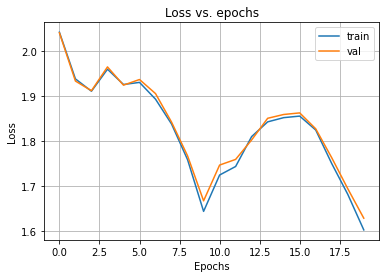

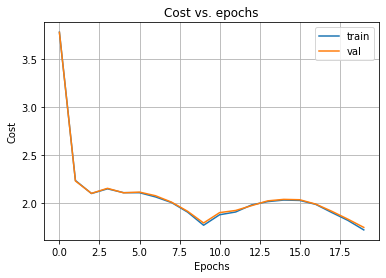

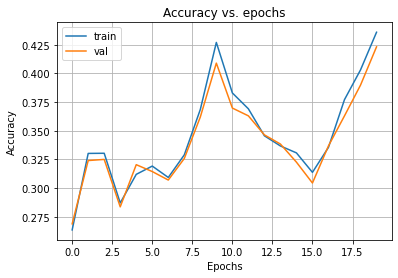

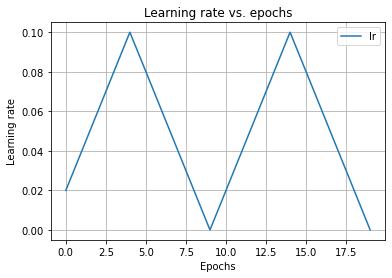

test acc: {'accuracy': 0.4337}


In [7]:
in_dim = x_train.shape[1]
out_dim = np.unique(y_train).size

# 5 layer, max depth
dims = [50, 30, 20, 10]

reg_rate = 0.2
seed = 10

model, loss, dims = build_model(dims, reg_rate, in_dim, out_dim, seed)
model = compile_model(model, loss, step_size)

verbose = 2
history = model.fit(x_train, y_train, x_val, y_val, n_epochs, batch_size, verbose, aug_func)

plot_losses(history, None)
plot_costs(history, None)
plot_accuracies(history, None)
plot_lrs(history, None)

params_val = {"mode": "test"}
scores_test = model.forward(x_test, **params_val)
y_hat_test = np.argmax(scores_test, axis=1)
metrics_test = model.compute_metrics(y_test, scores_test)
print(f"test acc: {metrics_test}")

Let's see some of the correct and incorrect predicitions of the trained model.

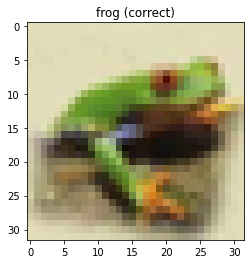

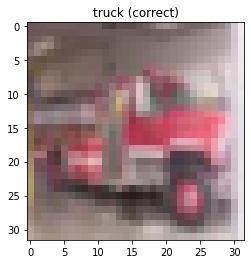

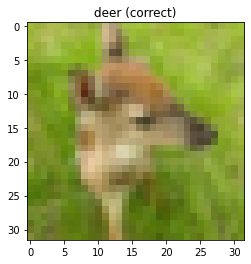

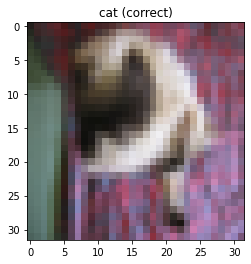

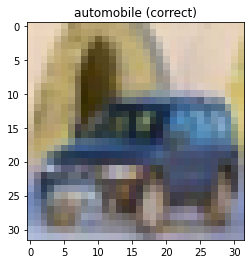

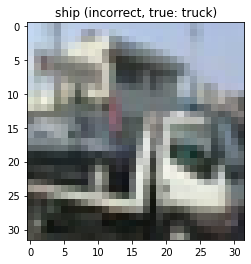

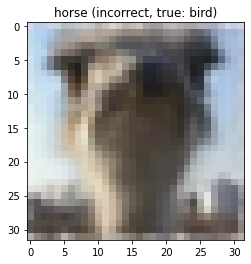

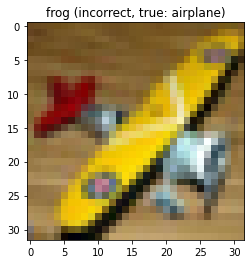

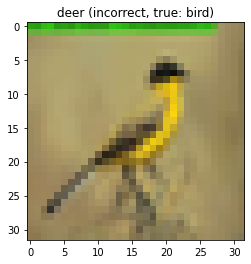

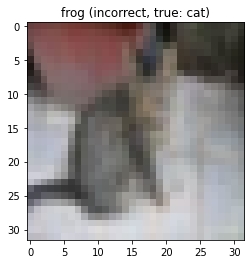

In [8]:
label_names = load_label_names()
correct_preds_indices = np.argwhere(y_hat_test == y_test).flatten()
incorrect_preds_indices = np.argwhere(y_hat_test != y_test).flatten()
np.random.seed(123)
np.random.shuffle(correct_preds_indices)
np.random.seed(123)
np.random.shuffle(incorrect_preds_indices)

for preds_idx in np.hstack([correct_preds_indices[:5], incorrect_preds_indices[:5]]):
    plt.imshow(x_test_img[preds_idx])
    
    pred_label = label_names[y_hat_test[preds_idx]]
    true_label = label_names[y_test[preds_idx]]
    title = \
        f"{pred_label} (correct)" \
        if pred_label == true_label \
        else f"{pred_label} (incorrect, true: {true_label})"
    plt.title(title) 
    plt.show()

## Hyperparameter Search <a class="anchor" id="hyperparameter-search"></a>

Hyperparamter search is carried out to find the best combination of the newtwork depth (number of layers) and the L2 regularization rate. As in ```two-layer.ipynb```, the [hyperopt](#https://github.com/hyperopt/hyperopt), a Bayesian, distributed hyperparameter optimization library is used.

Each run in the search goes on for 20 epochs. The best model is then re-trained for 30 epochs on the combination of the training and the validation (train-val) set, the test metrics of which are reported as a measure of the model performance on unseen data.

In [9]:
def objective(x_train, y_train, x_val, y_val, aug_func, batch_size, n_epochs, step_size, **kwargs):
    seed = 12

    in_dim = x_train.shape[1]
    out_dim = 10

    reg_rate = kwargs["reg_rate"]
    dims = kwargs["dims"]

    model, loss, dims = build_model(dims, reg_rate, in_dim, out_dim, seed)
    model = compile_model(model, loss, step_size)

    verbose = 1
    history = model.fit(x_train, y_train, x_val, y_val, n_epochs, batch_size, verbose, aug_func)

    params_val = {"mode": "test"}
    scores_val = model.forward(x_val, **params_val)
    y_hat_val = np.argmax(scores_val, axis=1)
    metrics_val = model.compute_metrics(y_val, scores_val)
    print(f"val acc: {metrics_val}")
    val_acc = metrics_val['accuracy']

    return {
        'loss': -val_acc,
        'status': STATUS_OK,
        # -- store other results like this
        'eval_time': time.time(),
        'val_acc': val_acc,
        'reg_rate': reg_rate,
        'n_layers': len(dims) - 1,
        'dims': dims
    }


def run_trials(x_train, y_train, x_val, y_val, aug_func, batch_size, n_epcohs, step_size, k_layer_hyperopt_path):
    # how many additional trials to do after loading saved trials. 1 = save after iteration
    trials_step = 1
    
    # initial max_trials. put something small to not have to wait
    max_trials = 2

    # try to load an already saved trials object, and increase the max
    try:
        trials = pickle.load(open(k_layer_hyperopt_path, "rb"))
        print("Found saved Trials! Loading...")
        max_trials = len(trials.trials) + trials_step
        print("Rerunning from {} trials to {} (+{}) trials".format(len(trials.trials), max_trials, trials_step))
        
    # create a new trials object and start searching
    except:
        trials = Trials()

    objective_lambda = lambda kwargs: objective(x_train, y_train, x_val, y_val, aug_func, 
                                                batch_size, n_epochs, step_size, **kwargs)

    dims_options = [
        (50, 30, 20, 10),
        (50, 30, 20),
        (50, 30)
    ]

    reg_limits = (0.01, 0.2)

    space = {
        "reg_rate": hp.uniform("reg_rate", reg_limits[0], reg_limits[1]),
        "dims": hp.choice("dims", dims_options)
    }

    best = fmin(objective_lambda,
                space=space,
                algo=tpe.suggest,
                max_evals=max_trials,
                trials=trials)

    print("Best:", best)

    # save the trials object
    with open(k_layer_hyperopt_path, "wb") as f:
        pickle.dump(trials, f)

Derive the number of epochs needed that is equivalent of the desired number of cylical learning rate schedule cylces. Here 20 epochs.

In [10]:
batch_size = 100

step_size = int(5*np.floor(x_train.shape[0] / batch_size))
print(f"step size of cyc. lr: {step_size} update steps")

cycle_steps = 2*step_size
print(f"full cycle of cyc.lr : {cycle_steps} update steps")

epochs_one_full_cycle = (cycle_steps * batch_size) / x_train.shape[0]
print(f"{epochs_one_full_cycle} epochs = 1 full cycle = {cycle_steps} update steps")

n_cycle = 2
n_epochs = int(n_cycle*epochs_one_full_cycle)
print(f"{n_cycle} cycle = {n_epochs} epochs = {n_cycle*cycle_steps} update steps")

step size of cyc. lr: 2250 update steps
full cycle of cyc.lr : 4500 update steps
10.0 epochs = 1 full cycle = 4500 update steps
2 cycle = 20 epochs = 9000 update steps


In [11]:
# loop indefinitely and stop whenever you like
run_for = 3
k_layer_hyperopt_path = "assets/k_layer/klayer.hyperopt"

for i in range(run_for):
    run_trials(x_train, y_train, x_val, y_val, aug_func, batch_size, n_epochs, step_size, k_layer_hyperopt_path)

Found saved Trials! Loading...
Rerunning from 4 trials to 5 (+1) trials
len(dims)-1 = 5                                      
model summary:                                       
layer 0: dense: 
	 shape -- in: 3072, out: 50
	 w -- init: Xavier ~ 1.000000 x N(0.000000, 0.018042^2), reg: l2 with 1.8443e-02
	 b -- init: Xavier ~ 1.000000 x N(0.000000, 1.000000^2)
	 activation: relu

layer 1: batch norm with momentum 0.9
layer 2: dropout with p=0.9
layer 3: dense: 
	 shape -- in: 50, out: 30
	 w -- init: Xavier ~ 1.000000 x N(0.000000, 0.141421^2), reg: l2 with 1.8443e-02
	 b -- init: Xavier ~ 1.000000 x N(0.000000, 1.000000^2)
	 activation: relu

layer 4: batch norm with momentum 0.9
layer 5: dropout with p=0.9
layer 6: dense: 
	 shape -- in: 30, out: 20
	 w -- init: Xavier ~ 1.000000 x N(0.000000, 0.182574^2), reg: l2 with 1.8443e-02
	 b -- init: Xavier ~ 1.000000 x N(0.000000, 1.000000^2)
	 activation: relu

layer 7: batch norm with momentum 0.9
layer 8: dropout with p=0.9
layer 9: de

starting epoch: 1 ...                                
epoch 1/20                                           
 	 -- train loss = 2.1021013615327493 / train cost = 3.0582299457081477
	 -- {"accuracy_train": 0.23457777777777777} 
	 -- val loss = 2.106742619084735 / val cost = 3.0628712032601335
	 -- {"accuracy_val": 0.2358} 


starting epoch: 2 ...                                
epoch 2/20                                           
 	 -- train loss = 1.7836528298871188 / train cost = 2.3952806592901648
	 -- {"accuracy_train": 0.35402222222222224} 
	 -- val loss = 1.8023084626336503 / val cost = 2.4139362920366962
	 -- {"accuracy_val": 0.347} 


starting epoch: 3 ...                                
epoch 3/20                                           
 	 -- train loss = 1.7134337045425287 / train cost = 2.0895901009301285
	 -- {"accuracy_train": 0.38008888888888887} 
	 -- val loss = 1.737523955099472 / val cost = 2.113680351487072
	 -- {"accuracy_val": 0.3622} 


starting epoch: 4 ...     

starting epoch: 3 ...                                
epoch 3/20                                           
 	 -- train loss = 1.6907396040693707 / train cost = 1.889546929998687
	 -- {"accuracy_train": 0.39797777777777776} 
	 -- val loss = 1.70294566444503 / val cost = 1.9017529903743462
	 -- {"accuracy_val": 0.3906} 


starting epoch: 4 ...                                
epoch 4/20                                           
 	 -- train loss = 1.7102590267220654 / train cost = 1.9011752484954587
	 -- {"accuracy_train": 0.39613333333333334} 
	 -- val loss = 1.7228192430526914 / val cost = 1.9137354648260847
	 -- {"accuracy_val": 0.3872} 


starting epoch: 5 ...                                
epoch 5/20                                           
 	 -- train loss = 1.7285709641612816 / train cost = 1.9186808677627272
	 -- {"accuracy_train": 0.3796888888888889} 
	 -- val loss = 1.747420915898851 / val cost = 1.9375308195002965
	 -- {"accuracy_val": 0.3666} 


starting epoch: 6 ...      

Load the best performing model with the network depth and L2 regularization stregth found from the hyperparameter search. 

In [12]:
k_layer_hyperopt_csv_path = "assets/k_layer/klayer.csv"

trials = pickle.load(open(k_layer_hyperopt_path, "rb"))
print(len(trials.trials))
print(trials.results)

best_trial = max(trials.results, key=lambda x: x['val_acc'])
print("best_trial")
print(best_trial)

df = pd.DataFrame(trials.results)
df["val_acc"] = df["loss"] * -1
df = df.drop(['status', 'eval_time', 'loss', 'dims'], 1)
df.to_csv(k_layer_hyperopt_csv_path)

df

7
[{'loss': -0.5004, 'status': 'ok', 'eval_time': 1629915934.5592592, 'val_acc': 0.5004, 'reg_rate': 0.019240294501572188, 'n_layers': 5, 'dims': [3072, 50, 30, 20, 10, 10]}, {'loss': -0.455, 'status': 'ok', 'eval_time': 1629916160.4795947, 'val_acc': 0.455, 'reg_rate': 0.13214421822496275, 'n_layers': 4, 'dims': [3072, 50, 30, 20, 10]}, {'loss': -0.4572, 'status': 'ok', 'eval_time': 1629916392.15205, 'val_acc': 0.4572, 'reg_rate': 0.18615281251620688, 'n_layers': 3, 'dims': [3072, 50, 30, 10]}, {'loss': -0.4862, 'status': 'ok', 'eval_time': 1629916637.427237, 'val_acc': 0.4862, 'reg_rate': 0.06244968837267639, 'n_layers': 3, 'dims': [3072, 50, 30, 10]}, {'loss': -0.506, 'status': 'ok', 'eval_time': 1631284162.8050916, 'val_acc': 0.506, 'reg_rate': 0.018442837925266218, 'n_layers': 4, 'dims': [3072, 50, 30, 20, 10]}, {'loss': -0.4994, 'status': 'ok', 'eval_time': 1631284389.9962392, 'val_acc': 0.4994, 'reg_rate': 0.01865445340668206, 'n_layers': 5, 'dims': [3072, 50, 30, 20, 10, 10]}, 

,val_acc,reg_rate,n_layers
0,0.5004,0.019240,5
1,0.4550,0.132144,4
2,0.4572,0.186153,3
3,0.4862,0.062450,3
4,0.5060,0.018443,4
5,0.4994,0.018654,5
6,0.4880,0.055519,3


Derive the number of epochs needed that is equivalent of the desired number of cylical learning rate schedule cylces. Here 30 epochs and on the combination of the train-val dataset. accuracy_val is irrelevant, as we only test on the unseen test set after training on the combined train-val dataset.

In [13]:
batch_size = 100

# train best model on train-val
x_train_val = np.vstack([x_train, x_val])
y_train_val = np.hstack([y_train, y_val])
print(f"trainval: x_train_val.shape = {x_train_val.shape}, y_train_val.shape = {y_train_val.shape}")

step_size = int(5*np.floor(x_train_val.shape[0] / batch_size))
print(f"step size of cyc. lr: {step_size} update steps")

cycle_steps = 2*step_size
print(f"full cycle of cyc.lr : {cycle_steps} update steps")

epochs_one_full_cycle = (cycle_steps * batch_size) / x_train_val.shape[0]
print(f"{epochs_one_full_cycle} epochs = 1 full cycle = {cycle_steps} update steps")

n_cycle = 3
n_epochs = int(n_cycle*epochs_one_full_cycle)
print(f"{n_cycle} cycle = {n_epochs} epochs = {n_cycle*cycle_steps} update steps")

trainval: x_train_val.shape = (50000, 3072), y_train_val.shape = (50000,)
step size of cyc. lr: 2500 update steps
full cycle of cyc.lr : 5000 update steps
10.0 epochs = 1 full cycle = 5000 update steps
3 cycle = 30 epochs = 15000 update steps


len(dims)-1 = 4
model summary: 
layer 0: dense: 
	 shape -- in: 3072, out: 50
	 w -- init: Xavier ~ 1.000000 x N(0.000000, 0.018042^2), reg: l2 with 1.8443e-02
	 b -- init: Xavier ~ 1.000000 x N(0.000000, 1.000000^2)
	 activation: relu

layer 1: batch norm with momentum 0.9
layer 2: dropout with p=0.9
layer 3: dense: 
	 shape -- in: 50, out: 30
	 w -- init: Xavier ~ 1.000000 x N(0.000000, 0.141421^2), reg: l2 with 1.8443e-02
	 b -- init: Xavier ~ 1.000000 x N(0.000000, 1.000000^2)
	 activation: relu

layer 4: batch norm with momentum 0.9
layer 5: dropout with p=0.9
layer 6: dense: 
	 shape -- in: 30, out: 20
	 w -- init: Xavier ~ 1.000000 x N(0.000000, 0.182574^2), reg: l2 with 1.8443e-02
	 b -- init: Xavier ~ 1.000000 x N(0.000000, 1.000000^2)
	 activation: relu

layer 7: batch norm with momentum 0.9
layer 8: dropout with p=0.9
layer 9: dense: 
	 shape -- in: 20, out: 10
	 w -- init: Xavier ~ 1.000000 x N(0.000000, 0.223607^2), reg: l2 with 1.8443e-02
	 b -- init: Xavier ~ 1.000000 x 

batch 500/500: 100%|██████████| 500/500 [00:11<00:00, 42.12it/s]
epoch 25/30 
 	 -- train loss = 1.5292335404678405 / train cost = 1.6827918864046234
	 -- {"accuracy_train": 0.45796} 
	 -- val loss = 2.4428601588432866 / val cost = 2.596418504780069
	 -- {"accuracy_val": 0.0} 


starting epoch: 26 ...
batch 500/500: 100%|██████████| 500/500 [00:11<00:00, 42.20it/s]
epoch 26/30 
 	 -- train loss = 1.44706081395088 / train cost = 1.5938857772285524
	 -- {"accuracy_train": 0.48566} 
	 -- val loss = 2.1686460859906997 / val cost = 2.315471049268372
	 -- {"accuracy_val": 0.0} 


starting epoch: 27 ...
batch 500/500: 100%|██████████| 500/500 [00:11<00:00, 41.91it/s]
epoch 27/30 
 	 -- train loss = 1.4121978575164231 / train cost = 1.5501312872170163
	 -- {"accuracy_train": 0.50058} 
	 -- val loss = 1.23853205009653 / val cost = 1.376465479797123
	 -- {"accuracy_val": 0.5} 


starting epoch: 28 ...
batch 500/500: 100%|██████████| 500/500 [00:11<00:00, 42.15it/s]
epoch 28/30 
 	 -- train loss 

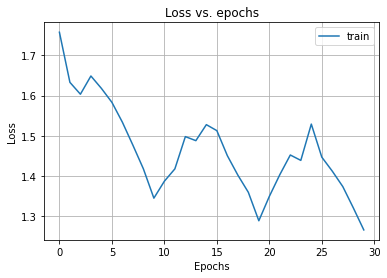

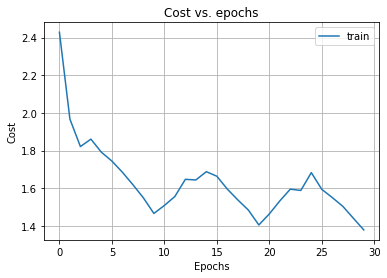

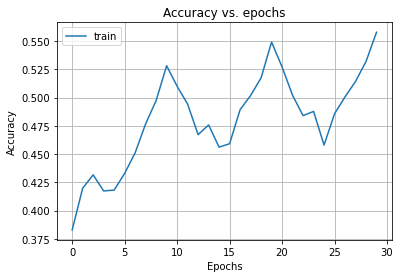

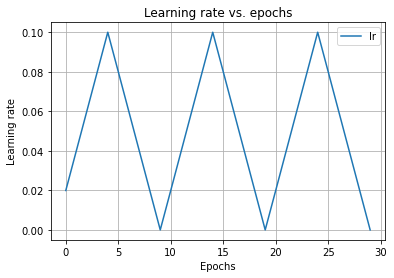

test acc: {'accuracy': 0.5207}


In [14]:
# best hyperparams
dims = best_trial["dims"][1:-1]
reg_rate = best_trial["reg_rate"]

in_dim = x_train.shape[1]
out_dim = np.unique(y_train).size

seed = 10
model, loss, dims = build_model(dims, reg_rate, in_dim, out_dim, seed)
model = compile_model(model, loss, step_size)

verbose = 2
history = model.fit(x_train_val, y_train_val, x_val[:2], y_val[:2], n_epochs, batch_size, verbose, aug_func)

path_save_losses = "assets/k_layer/losses.png"
path_save_costs = "assets/k_layer/costs.png"
path_save_accuracies = "assets/k_layer/accuracies.png"
path_save_lrs = "assets/k_layer/lrs.png"
plot_losses(history, path_save_losses, show_val=False)
plot_costs(history, path_save_costs, show_val=False)
plot_accuracies(history, path_save_accuracies, show_val=False)
plot_lrs(history, path_save_lrs)

params_val = {"mode": "test"}
scores_test = model.forward(x_test, **params_val)
y_hat_test = np.argmax(scores_test, axis=1)
metrics_test = model.compute_metrics(y_test, scores_test)
print(f"test acc: {metrics_test}")